# Fine-tuning the top layers of a pre-trained network

To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

- instantiate the convolutional base of VGG16 and load its weights
- add our previously defined fully-connected model on top, and load its weights
- freeze the layers of the VGG16 model up to the last convolutional block

![](vgg16_modified.png)

Note that:

- in order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.
- we choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).
- fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.
You can find the full code for this experiment [here](https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975).

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model

Using TensorFlow backend.


In [2]:
# path to the model weights files.
top_model_weights_path = 'fc_model.h5'

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 10
batch_size = 16

In [3]:
# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

After instantiating the VGG base and loading its weights, we add our previously trained fully-connected classifier on top:

In [4]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [5]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

In [6]:
# add the model on top of the convolutional base
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

We then proceed to freeze all convolutional layers up to the last convolutional block:

In [7]:
# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

In [8]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

Finally, we start training the whole thing, with a very slow learning rate:

In [9]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [11]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
125/125 [==============================] - 53s - loss: 0.4558 - acc: 0.8215 - val_loss: 0.4030 - val_acc: 0.8525
Epoch 2/10
125/125 [==============================] - 50s - loss: 0.2522 - acc: 0.9045 - val_loss: 0.3948 - val_acc: 0.8875
Epoch 3/10
125/125 [==============================] - 50s - loss: 0.2239 - acc: 0.9265 - val_loss: 0.3044 - val_acc: 0.9038
Epoch 4/10
125/125 [==============================] - 50s - loss: 0.1800 - acc: 0.9340 - val_loss: 0.3111 - val_acc: 0.9062
Epoch 5/10
125/125 [==============================] - 50s - loss: 0.1461 - acc: 0.9465 - val_loss: 0.2170 - val_acc: 0.9200
Epoch 6/10
125/125 [==============================] - 51s - loss: 0.1376 - acc: 0.9510 - val_loss: 0.3370 - val_acc: 0.8925
Epoch 7/10
125/125 [==============================] - 51s - loss: 0.1126 - acc: 0.9615 - val_loss: 0.3593 - val_acc: 0.9038
Epoch 8/10
125/125 [==============================] - 50s - loss: 0.1184 - acc: 0.9640 - val_loss: 0.2112 - val_acc: 0.9062
Epoch 9/

This approach gets us to a validation accuracy of 0.94 after 50 epochs. Great success!

Here are a few more approaches you can try to get to above 0.95:

- more aggresive data augmentation
- more aggressive dropout
- use of L1 and L2 regularization (also known as "weight decay")
- fine-tuning one more convolutional block (alongside greater regularization)


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

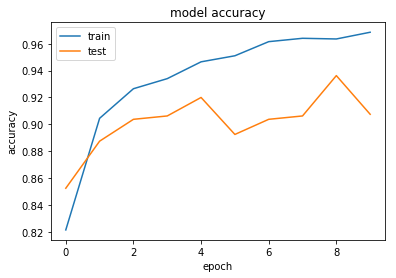

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

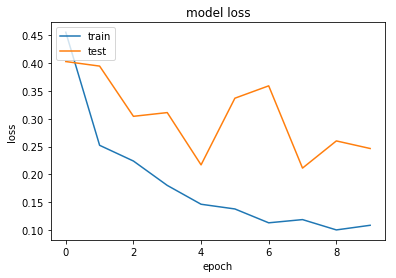

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');